# 💳 대출 승인 예측 - 의사결정나무 실습 (문제용)

이 노트북은 Kaggle Loan Approval Prediction Dataset(`loan.csv`)을 사용해
의사결정나무(Decision Tree)를 학습/평가/해석하는 방법을 연습합니다.

사용 컬럼 (loan.csv):
- loan_id
- no_of_dependents
- education (문자열: Graduate / Not Graduate 등)
- self_employed (Yes / No 등)
- income_annum (연간 소득)
- loan_amount (대출 금액)
- loan_term (상환 기간)
- cibil_score (신용 점수)
- residential_assets_value, commercial_assets_value,
  luxury_assets_value, bank_asset_value (자산 가치 지표들)
- loan_status (0=거절, 1=승인) ← 타깃 변수

학습 목표
1. 데이터 확인 & 전처리 (결측치 처리, 인코딩)
2. 학습/테스트 분리
3. 결정트리 학습 및 시각화
4. 정확도/혼동행렬로 성능 평가
5. 특성 중요도(Feature Importance) 해석
6. max_depth에 따른 과적합/일반화 비교

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
df = pd.read_csv("./data/08_loan_approval_dataset.csv")
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## 1️⃣ 데이터 구조 파악
- `df.shape`, `df.info()`, `df.head()`로 데이터 구조를 확인하세요.
- `loan_status` 값의 분포(`value_counts()`)를 출력하고 승인/거절의 불균형 여부를 설명하세요.

In [2]:
# TODO: df.shape, df.info(), df.head(), loan_status 분포 시각화
df.shape

(4269, 13)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [4]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
df.describe()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


In [6]:
df.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [7]:
df[' loan_status'].value_counts()

 loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

> 승인 데이터가 거절 데이터보다 많아, 클래스가 불균형하다

## 2️⃣ 결측치 처리
- 각 컬럼의 결측치 개수를 출력하세요: `df.isnull().sum()`
- 결측치 처리 규칙(학습용 간단 버전):
  - `education`, `self_employed` 처럼 범주형(object)은 최빈값(mode)으로 채운다.
  - 나머지 수치형(int/float)은 중앙값(median)으로 채운다.
- 결측치 처리 후 다시 `isnull().sum()`으로 확인하세요.

In [8]:
# TODO:
# df.isnull().sum() 출력 후 df_prep 생성, mode()/median()으로 결측치 채우기
df.isnull().sum() 

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

> 결측치 없음

## 3️⃣ 범주형 인코딩
- `education`, `self_employed`는 문자열 → 숫자로 변환해야 합니다.
- LabelEncoder를 사용하여 이 두 컬럼을 정수로 바꾸세요.
- 인코딩된 결과를 `df_encoded.head()`로 확인하세요.

In [9]:
df.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [10]:
#범주형 문자열 데이터를 숫자(정수)러 변환할 때 사용 (sklearn의 LabelEncoder 객체 생성!!!)
# LabelEncoder를 사용해 컬럼 데이터를 숫자로 변환
df_encoded = df.copy()
le = LabelEncoder()      

# 인코딩할 범주형 컬럼 리스트,두 컬럼을 숫자로 바꾼다 
# fit_transform() 데이터를 학습하고 바로 변환까지 한 번에 할 수 있음
for col in [' education',' self_employed']:
    df_encoded[col] = le.fit_transform(df[col])
df_encoded.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,0,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,1,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,0,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,0,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,1,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## 4️⃣ 학습/테스트 분리
- 설명변수 X는 `loan_status`를 제외한 나머지 컬럼입니다.
- 타깃 y는 `loan_status`입니다.
- `train_test_split`으로 학습 80%, 테스트 20%로 나누세요 (`random_state=42`, `stratify=y`).
- X_train, X_test의 shape를 출력하세요.

In [17]:
df.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [18]:
# TODO:
# train_test_split 후 shape 출력
X = df.drop(columns=[' loan_status'])
y = df[' loan_status']

In [19]:
X

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000
4265,4266,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000
4266,4267,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000
4267,4268,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,14100000,5800000


In [20]:
y

0        Approved
1        Rejected
2        Rejected
3        Rejected
4        Rejected
          ...    
4264     Rejected
4265     Approved
4266     Rejected
4267     Approved
4268     Approved
Name:  loan_status, Length: 4269, dtype: object

* test_size: 전체 데이서 수에 따라서 8:2, 7:3, 6:4로 나눔
* random_state: 데이터를 섞는 코드, 랜덤스테이트에 따라 데이터 세트가 변경, 모델 성능에 영향을 줌
  * 똑같은 결과를 재현하기 위해서는 반드시 random_state를 맞춰주어야함
* stratify=y : y컬럼의 데이터 분포 비율을 똑같이 맞춰주는 역할

8:2 → test_size=0.2

7:3 → test_size=0.3 

6:4 → test_size=0.4

In [21]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
X_train.shape

(3415, 12)

In [28]:
X_test.shape

(854, 12)

## 5️⃣ 결정트리 학습 및 과적합 확인
- `DecisionTreeClassifier(random_state=42)`로 모델을 학습하세요.
- `DecisionTreeClassifier(max_depth=3, random_state=42)` 모델도 학습하세요.
- 각 모델에 대해 학습 정확도(train acc)와 테스트 정확도(test acc)를 비교하세요.
- 가지치기(max_depth 제한)가 과적합을 줄였는지 해석하세요.

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [12]:
# TODO:
# full tree와 max_depth=3 tree의 학습/테스트 정확도를 비교

In [33]:
df.dtypes
# 범주형 : education,self_employed   

loan_id                       int64
 no_of_dependents             int64
 education                   object
 self_employed               object
 income_annum                 int64
 loan_amount                  int64
 loan_term                    int64
 cibil_score                  int64
 residential_assets_value     int64
 commercial_assets_value      int64
 luxury_assets_value          int64
 bank_asset_value             int64
 loan_status                 object
dtype: object

In [34]:
cat_cols = [' education', ' self_employed']
X_train_ohe_df = pd.get_dummies(X_train, columns=cat_cols)
X_test_ohe_df = pd.get_dummies(X_test, columns=cat_cols)

In [35]:
X_test_ohe_df = X_test_ohe_df.reindex(columns=X_train_ohe_df.columns, fill_value=0)

#reindex(columns=...) : 훈련 데이터 컬럼 순서에 맞춰 정렬
#-> 훈련/테스트 컬럼 완전히 동일 → 모델에 바로 입력 가능

In [49]:
# Full Tree
dtc_full = DecisionTreeClassifier(random_state=42) # DecisionTreeClassifier 객체 생성, max_depth 제한 없음, 랜덤 시드 고정
dtc_full.fit(X_train_ohe_df, y_train)              # 학습 데이터로 모델 학습
pred_full = dtc_full.predict(X_test_ohe_df)        # 학습한 모델로 테스트 데이터 예측
print("Full Tree")
print("Test acc", accuracy_score(y_test, pred_full))          

train_pred_full = dtc_full.predict(X_train_ohe_df)
train_acc_full = accuracy_score(y_train, train_pred_full)  # 학습 정확도
print("Train Accuracy:", train_acc_full)

Full Tree
Test acc 0.9742388758782201
Train Accuracy: 1.0


In [48]:
# Max_depth=3 Tree
# pruned : 가지치기된
dtc_pruned = DecisionTreeClassifier(max_depth=3, random_state=42)
dtc_pruned.fit(X_train_ohe_df, y_train)
pred_pruned = dtc_pruned.predict(X_test_ohe_df)
print("Pruned Tree(max_depth=3)")
print("Test acc",accuracy_score(y_test, pred_pruned))

train_pred_pruned = dtc_pruned.predict(X_train_ohe_df)
train_acc_pruned = accuracy_score(y_train, train_pred_pruned)
print("Train Accuracy:", train_acc_pruned)

Pruned Tree(max_depth=3)
Test acc 0.9718969555035128
Train Accuracy: 0.9622254758418741


> Full Tree: train acc = 1.0, test acc = 0.97 → 학습 데이터에는 거의 완벽하지만, 학습 정확도가 너무 높아 약간 과적합 가능성 있음<br>
> Pruned Tree (max_depth=3): train acc = 0.96, test acc = 0.97 → 학습 정확도가 약간 낮아 과적합 완화, 테스트 성능 안정적

1. **Full Tree**:

   * 깊이 제한이 없어서 학습 데이터에 최대한 맞추려 함 → 학습 정확도는 매우 높음.
   * 하지만 테스트 데이터에서는 성능이 떨어질 수 있음 → 과적합(overfitting).

2. **Pruned Tree (max_depth=3)**:

   * 깊이를 3으로 제한해서 불필요한 가지 제거 → 모델이 너무 학습 데이터에만 맞추지 않음.
   * 학습 정확도는 조금 낮지만, 테스트 정확도는 더 안정됨 → 과적합 완화.

🔹 과적합(Overfitting)이란?

* 모델이 학습 데이터에는 너무 잘 맞지만, 새로운 데이터(테스트 데이터)에는 성능이 떨어지는 현상.
* 특징: **학습 정확도 >> 테스트 정확도**
* 해결 방법:

  * 가지치기(max_depth 제한)
  * 학습 데이터 늘리기
  * 규제(Regularization) 등

## 6️⃣ 결정트리 시각화
- `plot_tree(tree_limited, ...)`로 가지치기된 트리를 시각화하세요.
- `feature_names=X.columns`, `class_names=['Reject','Approve']` 형태로 표시하세요.
- 루트 노드 분기 기준이 되는 변수는 무엇이며, 그게 실제 대출 심사에서 왜 중요할까요?

In [50]:
# TODO:
# plot_tree로 tree_limited 시각화 후 첫 분기 변수 해석
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

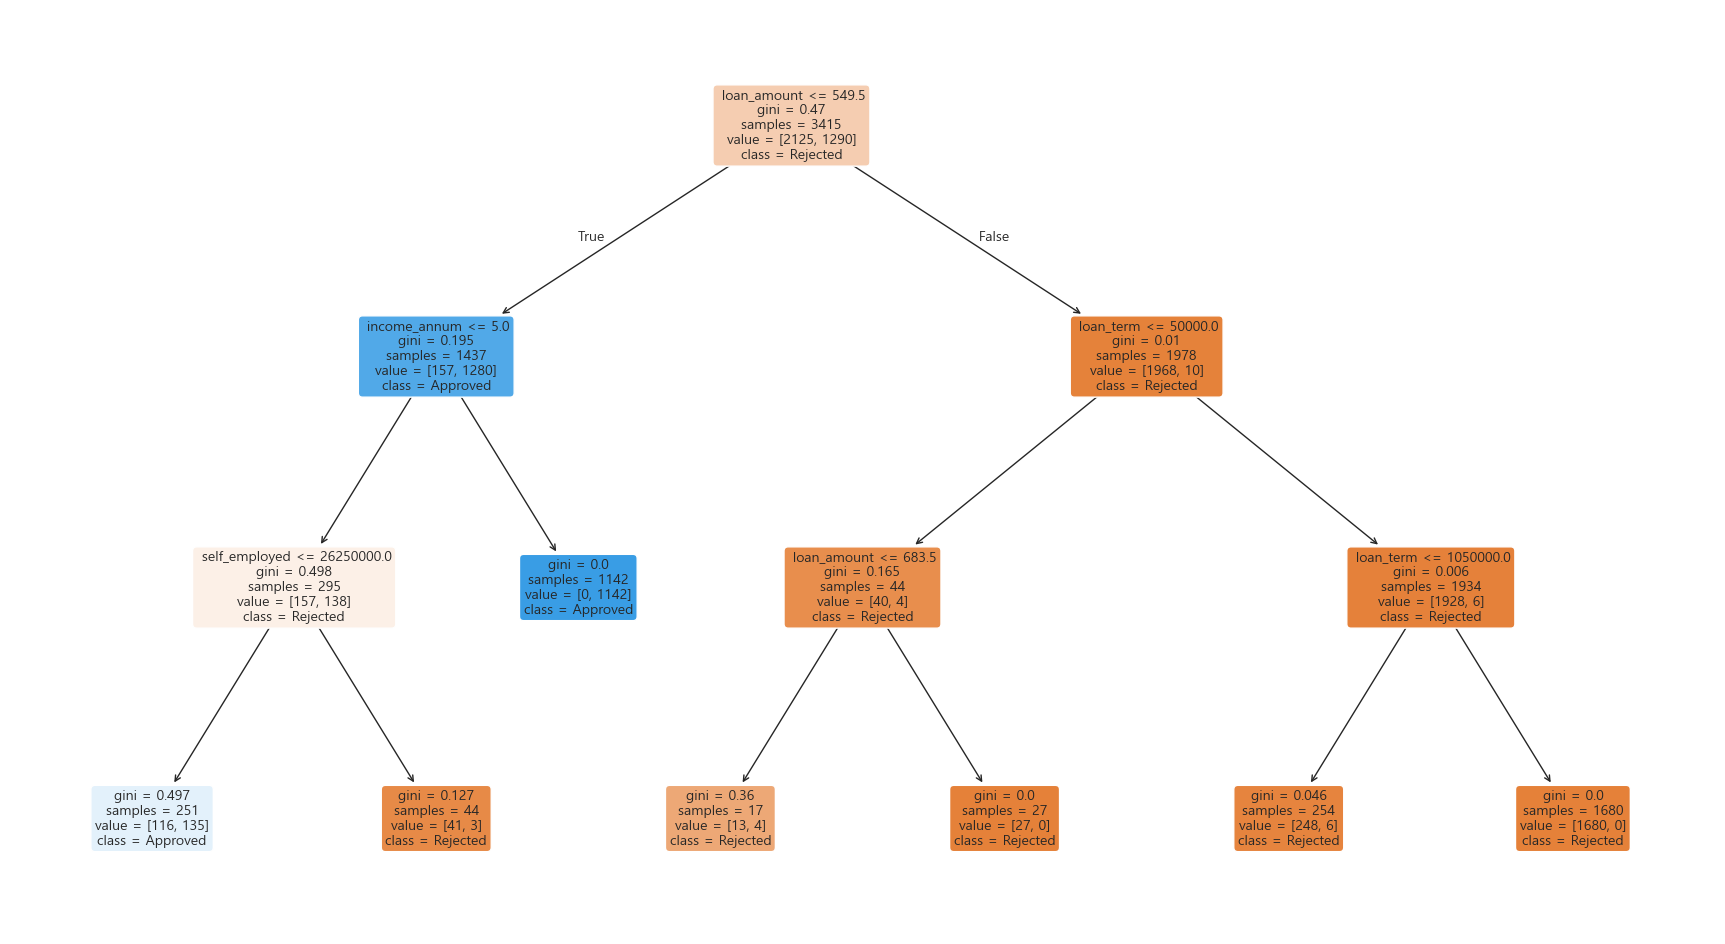

In [52]:
plt.figure(figsize=(22, 12))
plot_tree(dtc_pruned, feature_names=X.columns, class_names=['Rejected','Approved'],filled=True, rounded=True, fontsize=10)
plt.show()

> **루트 노드(root node)**란?

결정트리(Decision Tree)에서 **맨 위에 있는 첫 번째 분기 기준(조건)**
즉, 데이터를 처음으로 나누는 가장 중요한 변수입니다.

> 루트 노드: loan_amount <br>
대출 금액이 승인 여부를 결정하는 가장 중요한 기준임을 보여줌<br>
즉, 신청 금액이 높을수록 상환 부담이 커져 거절될 가능성이 높다고 볼 수 있음

## 7️⃣ 모델 평가 (혼동행렬 & 리포트)
- `tree_limited` 모델로 테스트셋을 예측하세요 (y_pred).
- `classification_report`와 `confusion_matrix`를 출력하세요.
- 어떤 오류가 더 치명적인지 설명하세요:
  - 승인해야 할 고객을 거절로 예측한 경우?
  - 거절해야 할 고객을 승인으로 예측한 경우?

In [53]:
# TODO:
# classification_report / confusion_matrix 출력 후 비즈니스 관점에서 해석

In [56]:
#테스트셋 예측
y_pred = dtc_pruned.predict(X_test_ohe_df)
y_pred

array([' Approved', ' Approved', ' Approved', ' Rejected', ' Approved',
       ' Rejected', ' Rejected', ' Approved', ' Approved', ' Approved',
       ' Approved', ' Approved', ' Rejected', ' Approved', ' Rejected',
       ' Approved', ' Approved', ' Rejected', ' Rejected', ' Approved',
       ' Rejected', ' Rejected', ' Rejected', ' Rejected', ' Approved',
       ' Approved', ' Approved', ' Approved', ' Approved', ' Rejected',
       ' Approved', ' Rejected', ' Approved', ' Approved', ' Approved',
       ' Rejected', ' Rejected', ' Rejected', ' Approved', ' Approved',
       ' Approved', ' Approved', ' Approved', ' Rejected', ' Rejected',
       ' Approved', ' Rejected', ' Approved', ' Approved', ' Rejected',
       ' Rejected', ' Approved', ' Approved', ' Approved', ' Approved',
       ' Approved', ' Rejected', ' Approved', ' Approved', ' Rejected',
       ' Rejected', ' Approved', ' Approved', ' Rejected', ' Rejected',
       ' Approved', ' Approved', ' Approved', ' Approved', ' Rej

In [58]:
# 혼동행렬 출력
print("혼동행렬")
print(confusion_matrix(y_test, y_pred))

혼동행렬
[[510  21]
 [  3 320]]


In [60]:
# - 모델의 예측 결과를 실제값(y_test)과 비교해서
#   어떤 항목을 맞췄고, 어떤 항목을 틀렸는지를 행렬 형태로 보여줌.
# - [[TN, FP], [FN, TP]] 구조:
#     TN: 거절을 거절로 예측 (정상)
#     FP: 거절해야 하는데 승인으로 예측 x→ 은행에 치명적
#     FN: 승인해야 하는데 거절로 예측 x → 기회 손실
#     TP: 승인을 승인으로 예측 (정상)

In [59]:
# 분류 리포트 출력
print("분류 리포트")
print(classification_report(y_test, y_pred, target_names=['Rejected', 'Approved']))

분류 리포트
              precision    recall  f1-score   support

    Rejected       0.99      0.96      0.98       531
    Approved       0.94      0.99      0.96       323

    accuracy                           0.97       854
   macro avg       0.97      0.98      0.97       854
weighted avg       0.97      0.97      0.97       854



In [61]:
# - 모델의 성능을 정량적으로 평가하는 보고서 형태로 보여줌.
# - precision(정밀도), recall(재현율), f1-score(균형 지표), accuracy(전체 정확도) 포함.
# - target_names=['Rejected', 'Approved'] :
#   0과 1 대신 사람이 보기 쉬운 라벨 이름으로 표시하기 위해 넣음.

> 거절해야 할 고객을 승인으로 예측한 경우가 더 치명적<br>
부실 대출로 이어져 금융기관의 손실을 초래할 수 있기 때문

## 8️⃣ 변수 중요도 (Feature Importance)
- `tree_limited.feature_importances_`를 이용해 변수 중요도를 계산하세요.
- barplot으로 내림차순 시각화하세요.
- 상위 중요한 변수 3개를 골라서, 금융적으로 납득이 되는지 서술하세요
  (예: cibil_score가 높을수록 승인될 가능성이 높다 → 신용점수 중요).

In [15]:
# TODO:
# feature_importances_ 시각화 및 상위 3개 변수 해석

In [62]:
feature_importance = pd.DataFrame({'Feature' : X_train_ohe_df.columns, 'Importance': dtc_pruned.feature_importances_})
feature_importance

,Feature,Importance
0,loan_id,0.000000
1,no_of_dependents,0.000000
2,income_annum,0.000000
3,loan_amount,0.011334
4,loan_term,0.091137
5,cibil_score,0.896905
6,residential_assets_value,0.000624
7,commercial_assets_value,0.000000
8,luxury_assets_value,0.000000
9,bank_asset_value,0.000000


In [63]:
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance

,Feature,Importance
5,cibil_score,0.896905
4,loan_term,0.091137
3,loan_amount,0.011334
6,residential_assets_value,0.000624
1,no_of_dependents,0.000000
0,loan_id,0.000000
2,income_annum,0.000000
7,commercial_assets_value,0.000000
8,luxury_assets_value,0.000000
9,bank_asset_value,0.000000


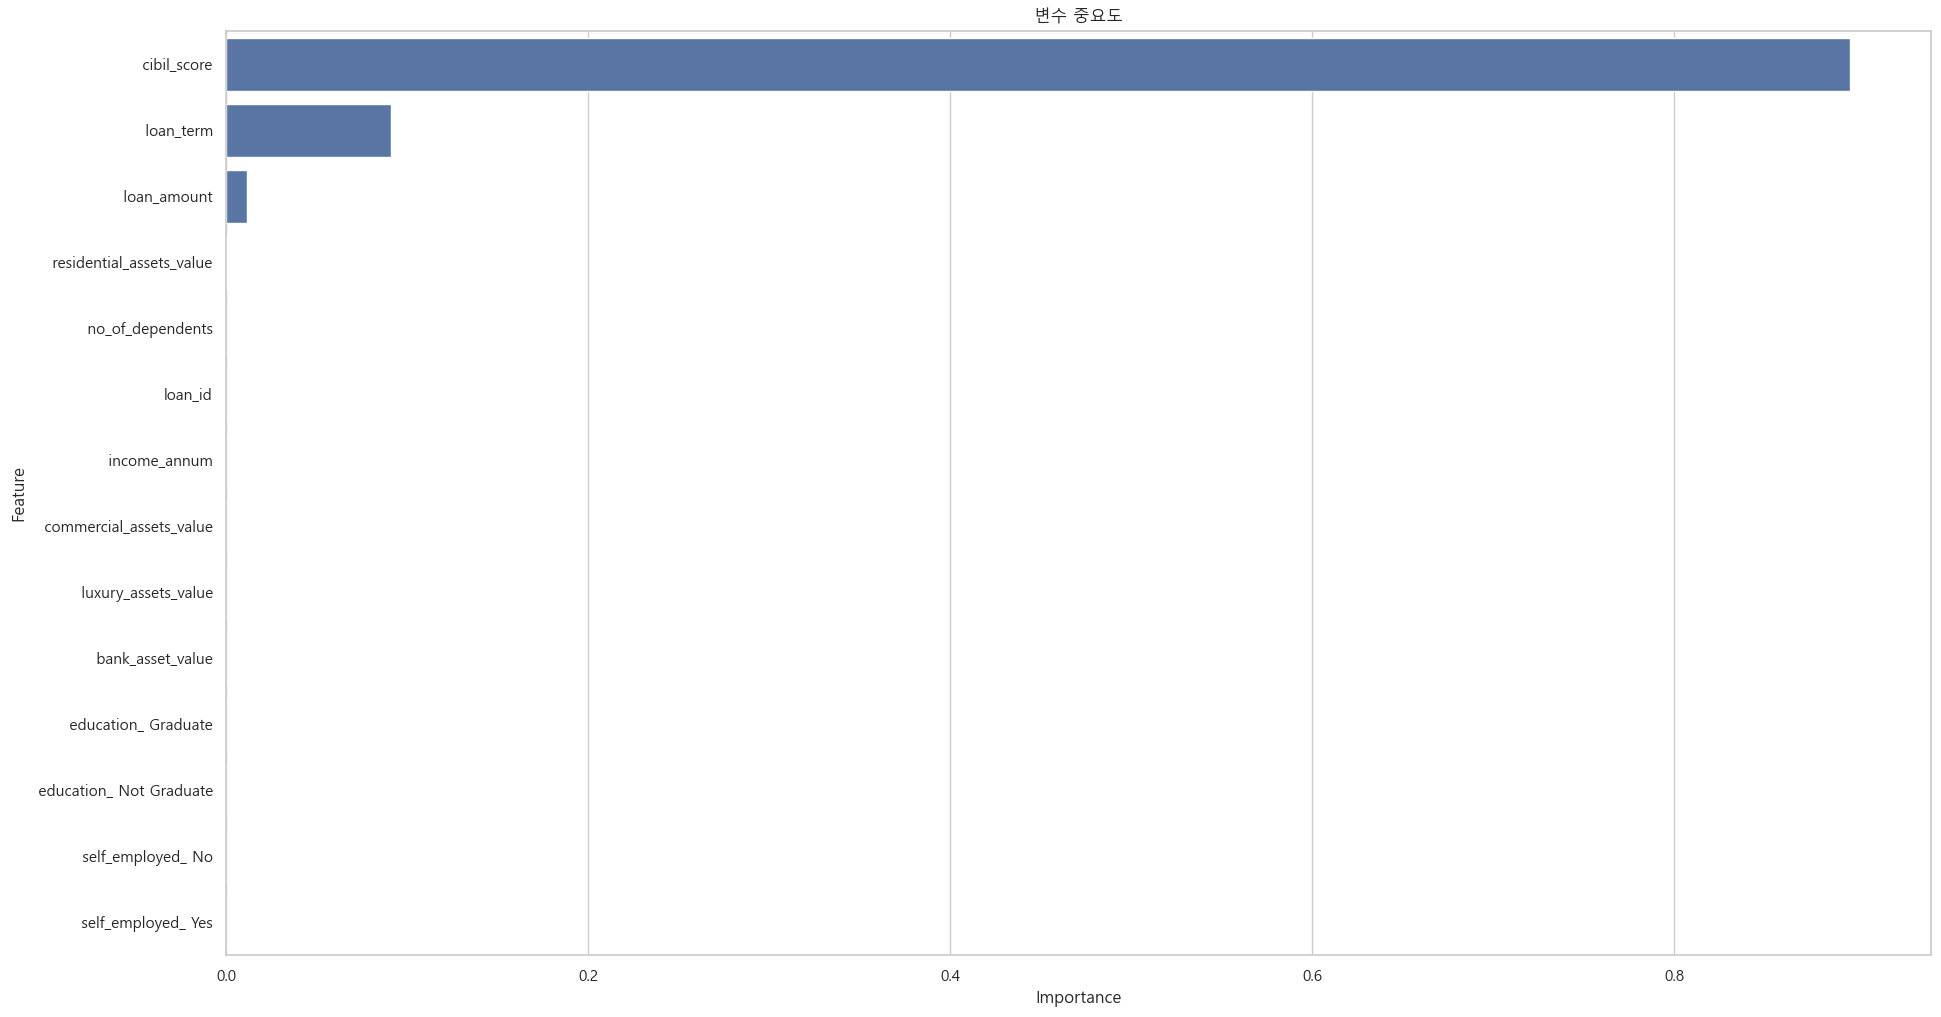

In [64]:
plt.figure(figsize=(22,12))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("변수 중요도")
plt.show()

In [65]:
top3 = feature_importance.head(3)
print("상위 3개 중요 변수:", top3)

상위 3개 중요 변수:         Feature  Importance
5   cibil_score    0.896905
4     loan_term    0.091137
3   loan_amount    0.011334


> 상위 3개 변수는 cibil_score, loan_term, loan_amount로 나타났음<br>
그중 cibil_score(신용점수)의 중요도가 압도적으로 높으므로 신용점수가 높을수록 대출 승인 가능성이 크게 증가함을 의미<br>
loan_term(대출 기간)은 상환 계획과 관련된 요소로, 기간이 길수록 위험도가 증가할 수 있으며,<br>
loan_amount(대출 금액)은 신청 금액이 커질수록 부담이 커져 승인 확률이 낮아지는 경향을 반영함

## 9️⃣ 가지치기(Pruning) 실험
- max_depth를 1~6으로 바꿔가며 모델을 학습하세요.
- 각 깊이에 대해 테스트 정확도를 기록하세요.
- (x=깊이, y=정확도) 선 그래프로 시각화하세요.
- 깊이가 커질수록 어떤 패턴(과적합/일반화 변화)이 나타나는지 해석하세요.

In [16]:
# TODO:
# max_depth별 accuracy를 그려보고 과적합/일반화 경향 설명

In [68]:
depths = range(1,7)
test_acc = []

for d in depths:
    dtc = DecisionTreeClassifier(max_depth=d, random_state=42)
    dtc.fit(X_train_ohe_df, y_train)
    y_pred = dtc.predict(X_test_ohe_df)
    acc = accuracy_score(y_test, y_pred)
    test_acc.append(acc)

for d, acc in zip(depths, test_acc):
    print(f"max_depth={d}. test_acc={acc:.4f}")

max_depth=1. test_acc=0.9637
max_depth=2. test_acc=0.9614
max_depth=3. test_acc=0.9719
max_depth=4. test_acc=0.9684
max_depth=5. test_acc=0.9778
max_depth=6. test_acc=0.9719


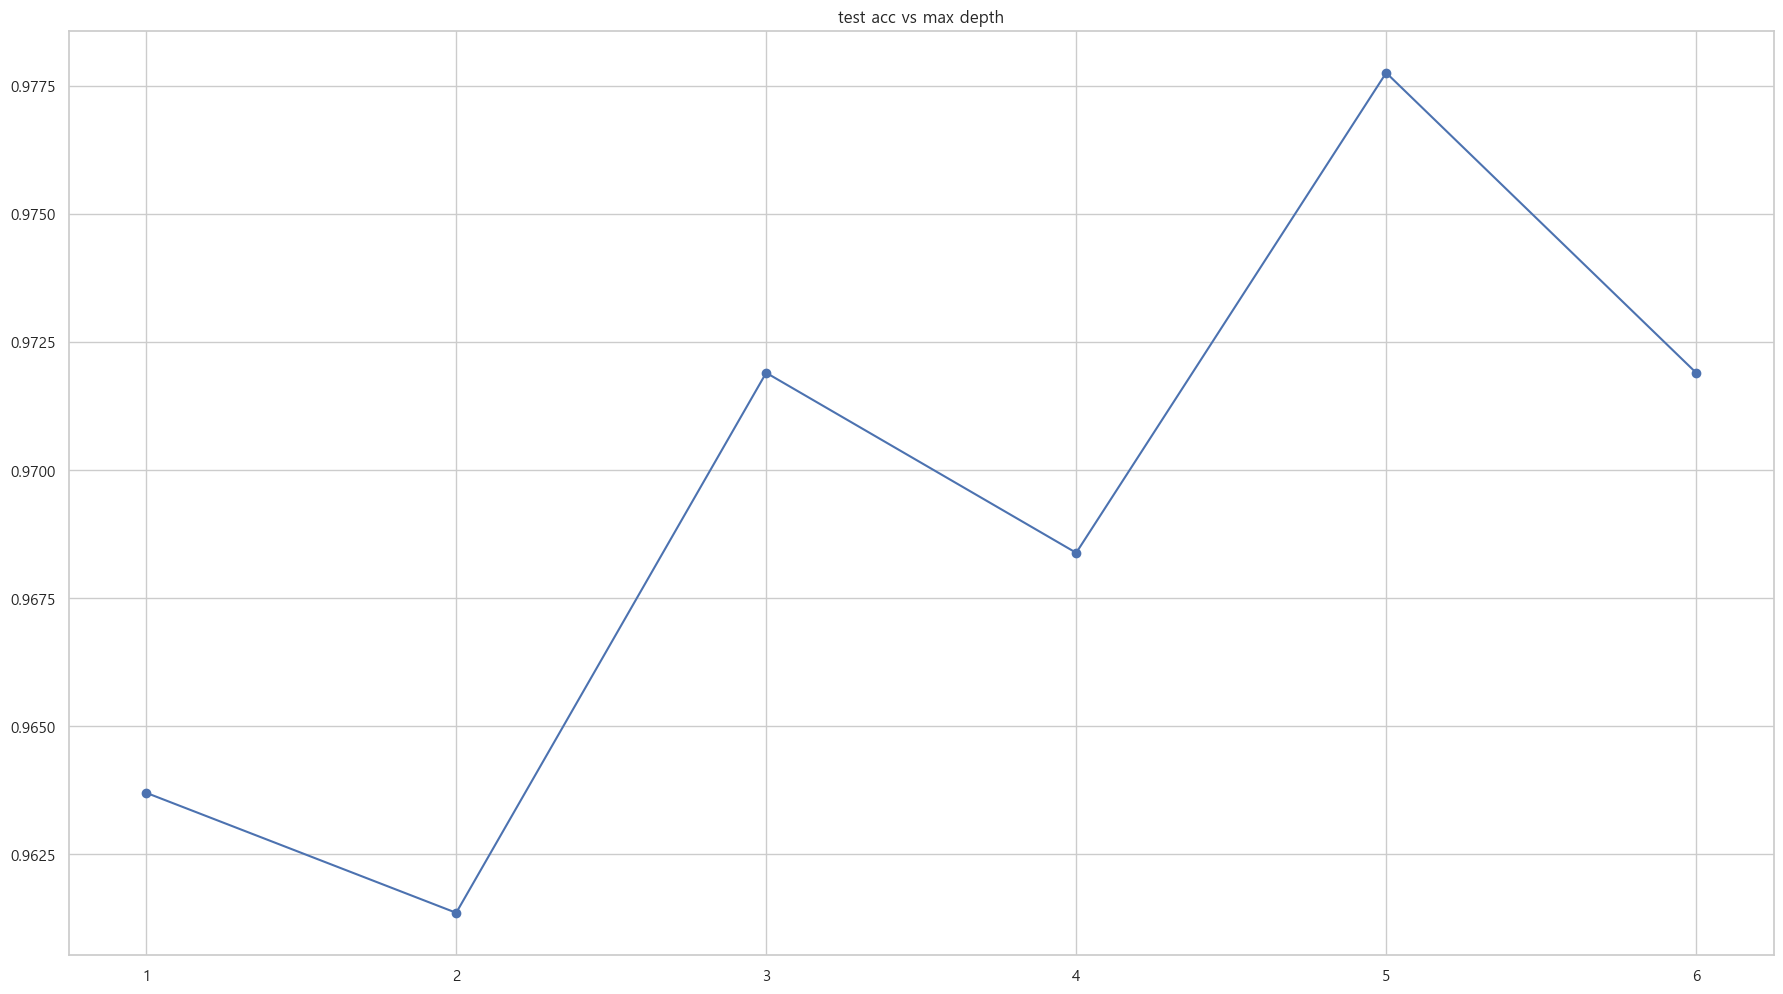

In [70]:
plt.figure(figsize=(22,12))
plt.plot(depths, test_acc, marker='o')
plt.title("test acc vs max depth")
plt.grid(True)
plt.show()

3️⃣ 해석 가이드

깊이가 낮을 때 (1~2)

트리가 너무 단순해서 학습 데이터 패턴을 충분히 잡지 못함 → underfitting(과소적합)

테스트 정확도가 낮음

깊이가 적당할 때 (3~4 정도)

학습과 테스트 정확도가 적절히 높음 → 일반화 잘됨

깊이가 너무 깊을 때 (5~6)

학습 정확도는 거의 1에 가까워지지만, 테스트 정확도가 일정하거나 약간 떨어질 수 있음 → overfitting(과적합)

모델이 학습 데이터에 너무 맞춰져서 새로운 데이터에서는 성능 저하 가능

## 🔟 비즈니스/핀테크 관점 해석 (서술형)
- 트리의 첫 분기(루트 노드)는 무엇인가요? 이건 어떤 리스크 판단 기준을 시사하나요?
- 잘못 승인(회수 불가능 위험) vs 잘못 거절(매출 기회 상실) 중 어떤 게 금융기관 입장에서 더 치명적인가요?
- 실제 핀테크 심사 서비스에 이 트리를 그대로 쓰려면 어떤 공정성·설명가능성(Explainability) 이슈가 있나요?

_여기에 본인 해석을 작성하세요._

루트 노드는 **신용점수(cibil_score)**로, 대출 상환 위험을 판단하는 핵심 기준입니다. 금융기관 입장에서는 **잘못 승인(회수 불가능 대출)**이 더 치명적이며, 실제 적용 시 **공정성과 설명가능성** 문제를 반드시 고려해야 합니다.


---
🎉 완료!
이제 금융(대출 승인) 데이터를 이용해 전처리 → 모델 학습 → 평가 → 해석 → 리스크 논의까지 한 번에 경험했습니다.
